c:\Users\queim\micromambaenv\envs\stpy39\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3670], dtype=torch.float64), std = tensor([1.2762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization terminated successfully.
         Current function value: 6.703278
         Iterations: 5
         Function evaluations: 11
A non-descent direction was encountered.
         Current function value: 6.703278
         Iterations: 8
         Function evaluations: 10
A non-descent direction was encountered.
         Current function value: 6.703278
         Iterations: 13
         Function evaluations: 17
A non-descent direction was encountered.
         Current function value: 6.703278
         Iterations: 8
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 6.703278
         Iterations: 5
         Function evaluations: 14
Kernel description:

	kernel: squared_exponential
	operation: -
	kappa=1.0
	group=[0]
	offset=0.0
	gamma=tensor([-0.0112], dtype=torch.float64)
lambda=0.001
Optimization terminated successfully.
         Current function value: -0.098023
         Iterations: 6
         Function evaluations: 9
Optimizatio

c:\users\queim\documents\eth\code\stpy\stpy\continuous_processes\gauss_procc.py:596: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  reduction='sum',delta = self.huber_delta) + self.lam * alpha.T @K_tch@ alpha


Optimization terminated successfully.
         Current function value: 2165.123576
         Iterations: 1
         Function evaluations: 6
Optimization terminated successfully.
         Current function value: 702.263514
         Iterations: 1
         Function evaluations: 9
Optimization terminated successfully.
         Current function value: 134.635071
         Iterations: 1
         Function evaluations: 7
Optimization terminated successfully.
         Current function value: 3041.307215
         Iterations: 1
         Function evaluations: 5
Optimization terminated successfully.
         Current function value: 791.485013
         Iterations: 1
         Function evaluations: 7
Kernel description:

	kernel: squared_exponential
	operation: -
	kappa=1.0
	group=[0]
	offset=0.0
	gamma=tensor([0.1193], dtype=torch.float64)
lambda=0.001


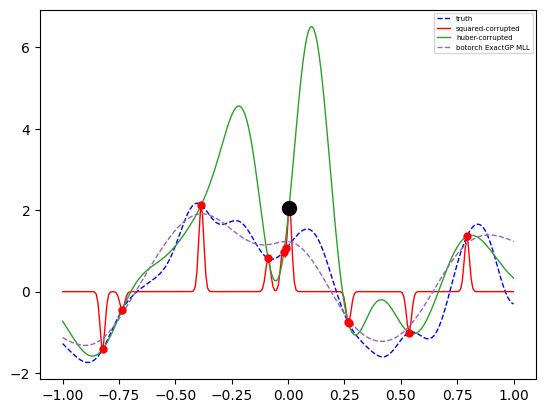

In [1]:
import torch
from stpy.continuous_processes.gauss_procc import GaussianProcess
from stpy.kernels import KernelFunction
from stpy.helpers.helper import interval
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood


# Parameters
N = 10
n = 256
d = 1
eps = 0.01
s = 1
gamma = 0.1

# Set random seed
torch.manual_seed(0)

# Generate random data
x = torch.rand(N, d).double() * 2 - 1
xtest = torch.from_numpy(interval(n, d, L_infinity_ball=1))

# True Gaussian process
GP_true = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d)
ytest = GP_true.sample(xtest)
GP_true.fit_gp(xtest, ytest)
y = GP_true.mean(x).clone()

# New data points
xnew = x[0, :].view(1, 1) + eps
ynew = y[0, 0].view(1, 1) + 1

# Combined data
x2 = torch.vstack([x, xnew])
y2 = torch.vstack([y, ynew])

# Initialize models
GP_huber_corrupted = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d, loss='huber', huber_delta=1.5)
GP_sqr_corrupted = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d)
GP_huber_uncorrupted = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d, loss='huber', huber_delta=1.5)
GP_sqr_uncorrupted = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d)

# gpytorch models
gp = SingleTaskGP(
    train_X=x2,
    train_Y=y2,
    input_transform=Normalize(d=d),
    # outcome_transform=Standardize(m=1),
)

# Fit models
GP_huber_corrupted.fit_gp(x2, y2)
GP_sqr_corrupted.fit_gp(x2, y2)
GP_huber_uncorrupted.fit_gp(x, y)
GP_sqr_uncorrupted.fit_gp(x, y)


# Optimize models
GP_sqr_corrupted.optimize_params(type="bandwidth", restarts=5, verbose=False, optimizer='pytorch-minimize', scale=1.)
GP_sqr_uncorrupted.optimize_params(type="bandwidth", restarts=5, verbose=False, optimizer='pytorch-minimize', scale=1.)
GP_huber_corrupted.optimize_params(type="bandwidth", restarts=5, verbose=False, optimizer='pytorch-minimize', scale=1., weight=1.)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# Predictions
mu_sqr_corrupted = GP_sqr_corrupted.mean(xtest)
mu_sqr_uncorrupted = GP_sqr_uncorrupted.mean(xtest)
mu_huber_corrupted = GP_huber_corrupted.mean(xtest)
mu_huber_uncorrupted = GP_huber_uncorrupted.mean(xtest)

mu = gp.posterior(xtest).mean.detach().numpy()
gp.likelihood.parameters()

# Plotting
plt.plot(xtest, GP_true.mean(xtest), 'b--', label="truth", lw=1)
plt.plot(xtest, mu_sqr_corrupted, 'r-', label="squared-corrupted", lw=1)
# plt.plot(xtest, mu_sqr_uncorrupted, '--x', color="tab:brown", label='squared-uncorrupted', lw=3)
plt.plot(xtest, mu_huber_corrupted, color="tab:green", label='huber-corrupted', lw=1)
# plt.plot(xtest, mu_huber_uncorrupted, '--', color="tab:orange", label='huber-uncorrupted', lw=3)
plt.plot(xtest, mu, '--', color="tab:purple", label='botorch ExactGP MLL', lw=1)

# Legend and display
plt.legend(loc='upper right', fontsize=5)
# Plot data points
plt.plot(x, y, 'ro', ms=5, label="data")
plt.plot(xnew, ynew, 'ko', ms=10, label="new data")

plt.show()


In [4]:
gp.likelihood.parameters

#print model parameters
print(gp.likelihood.parameters())

<generator object Module.parameters at 0x0000029150F52D60>


In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact
# import ipywidgets as widgets

# def huber_plot(huber_delta):
#     GP_huber_corrupted = GaussianProcess(gamma=gamma, kernel_name="squared_exponential", d=d, loss='squared', huber_delta=1.5)
#     GP_huber_corrupted.fit_gp(x2, y2)
#     GP_huber_corrupted.optimize_params(type="bandwidth+noise", restarts=20, verbose=False, optimizer='pytorch-minimize', scale=1., weight=1.)
#     mu_huber_corrupted = GP_huber_corrupted.mean(xtest)
#     return mu_huber_corrupted

# # Define the function to plot
# def plot_sine_wave(huber_delta):
    
#     mu_huber_corrupted = huber_plot(huber_delta)
#     plt.plot(xtest, mu_huber_corrupted, label="huber-corrupted", lw=3)
#     plt.plot(xtest, GP_true.mean(xtest), 'b--', label="truth", lw=3)
#     plt.plot(xtest, mu, '-', color="tab:purple", label='botorch ExactGP MLL', lw=3)
    
#     plt.plot(x, y, 'ro', ms=5, label="data")
#     plt.plot(xnew, ynew, 'ko', ms=10, label="new data")
#     plt.legend(loc='upper right', fontsize=5)
#     plt.show()

# # Create the slider and interactive plot
# interact(plot_sine_wave, huber_delta=widgets.FloatSlider(min=0.01, max=2, step=0.05, value=1.0))


In [6]:
y2.shape

torch.Size([11, 1])

Iteration 1/1000 - Loss: -0.2999154329299927
Iteration 2/1000 - Loss: -0.9249358773231506
Iteration 3/1000 - Loss: 0.11103972792625427
Iteration 4/1000 - Loss: -0.7729153633117676
Iteration 5/1000 - Loss: -0.0619206577539444
Iteration 6/1000 - Loss: 0.1115727499127388
Iteration 7/1000 - Loss: -0.010732300579547882
Iteration 8/1000 - Loss: 0.027796149253845215
Iteration 9/1000 - Loss: 0.111470066010952
Iteration 10/1000 - Loss: 0.11117448657751083
Iteration 11/1000 - Loss: 0.09768448024988174
Iteration 12/1000 - Loss: -0.14278839528560638
Iteration 13/1000 - Loss: -0.14468874037265778
Iteration 14/1000 - Loss: 0.1091793030500412
Iteration 15/1000 - Loss: -0.6209667325019836
Iteration 16/1000 - Loss: 0.0859370231628418
Iteration 17/1000 - Loss: 0.11134166270494461
Iteration 18/1000 - Loss: -0.21812507510185242
Iteration 19/1000 - Loss: -0.0850261002779007
Iteration 20/1000 - Loss: 0.10599667578935623
Iteration 21/1000 - Loss: 0.11126195639371872
Iteration 22/1000 - Loss: 0.05827541649341

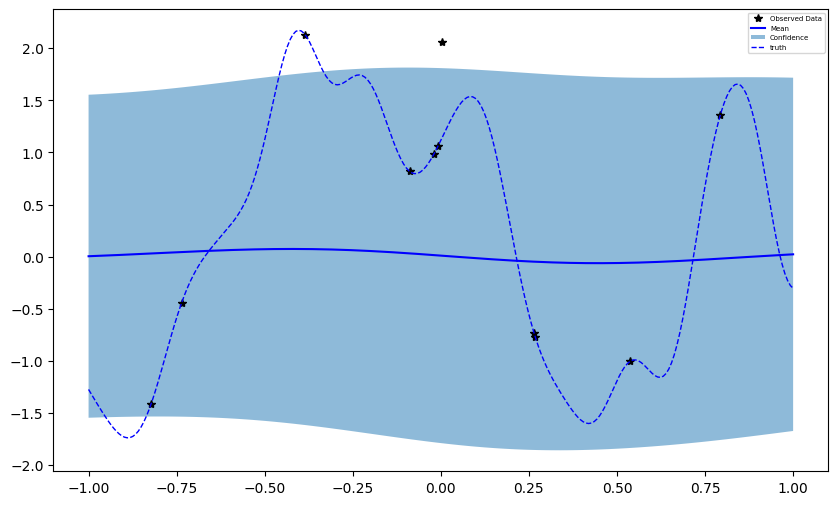

In [7]:
import gpytorch
from torch.distributions import Beta, Bernoulli, Uniform, Normal

# Define the variational GP model
class SimpleVariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SimpleVariationalGP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        
        lengthscale_prior = gpytorch.priors.GammaPrior(2.0, 5.0)
        outputscale_prior = gpytorch.priors.GammaPrior(2.0, 5.0)
        
        
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
                                                         outputscale_prior=outputscale_prior)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the custom likelihood
class MixtureLikelihood(gpytorch.likelihoods.Likelihood):
    def __init__(self, noise_variance=0.01, a_uniform=10.0, gamma_prior=(2.0, 5.0)):
        super().__init__()
        self.noise_variance = torch.tensor(noise_variance)
        self.a_uniform = a_uniform
        self.gamma_prior = Beta(torch.tensor(gamma_prior[0]), torch.tensor(gamma_prior[1]))
    
    def forward(self, function_samples, observation):
        # Bernoulli distribution for inliers/outliers
        gamma = self.gamma_prior.sample()  # Mixing coefficient for inliers
        z_prob = Bernoulli(probs=gamma)  # Indicator variable for each observation
        
        # Normal distribution for inliers
        normal_likelihood = Normal(function_samples, torch.sqrt(self.noise_variance))
        
        # Uniform distribution for outliers
        uniform_likelihood = Uniform(-self.a_uniform, self.a_uniform)
        
        # Compute mixture likelihood
        z_samples = z_prob.sample(sample_shape=function_samples.shape)  # Sample inliers/outliers
        log_likelihood = (z_samples) * normal_likelihood.log_prob(observation) + \
                         (1-z_samples) * uniform_likelihood.log_prob(observation)
        
        # return torch.exp(log_likelihood)
        return torch.exp(normal_likelihood.log_prob(observation))
    
    def expected_log_prob(self, target, function_dist, *args, **kwargs):
        function_samples = function_dist.rsample()  # Sample from the variational distribution
        return self.forward(function_samples, target)


train_x = x2.float().squeeze(-1)
train_y = y2.float().squeeze(-1)
inducing_points = train_x

# Initialize likelihood and model
likelihood = MixtureLikelihood(noise_variance=0.01, a_uniform=3.0, gamma_prior=(1.0, 2.0))
model = SimpleVariationalGP(inducing_points)

# Training the model
model.train()
likelihood.train()

# Use Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.001)

# Define variational ELBO loss
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())
# mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.numel())


# Training loop
n_iter = 1000
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print(f'Iteration {i + 1}/{n_iter} - Loss: {loss.item()}')

# Make predictions
model.eval()
likelihood.eval()

test_x = xtest.float().squeeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_preds = model(test_x)
    
# Plotting (optional, requires matplotlib)
import matplotlib.pyplot as plt

with torch.no_grad():
    lower, upper = test_preds.confidence_region()
    plt.figure(figsize=(10, 6))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
    plt.plot(test_x.numpy(), test_preds.mean.numpy(), 'b')
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    plt.plot(xtest, GP_true.mean(xtest), 'b--', label="truth", lw=1)
    plt.legend(['Observed Data', 'Mean', 'Confidence' , 'truth'], fontsize=5)
    plt.show()
